In [1]:
# Import required libraries
import warnings
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import statsmodels.api as sm

warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

Reading And Understanding The Data

In [2]:
# read dataframe
df = pd.read_csv('day.csv')

In [3]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [5]:
# checking for null values
df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [6]:
# dropping columns, not required for modeling
# 1) instant: not required , indicated row numbers
# 2) casual and registered: as our dependant variable is a count
# 3) dteday: 'dteday' and 'yr','month' contain the same data. to avoid confusion,we can drop the 'dteday' column

In [7]:
df.drop(['instant', 'casual','registered','dteday'],axis=1,inplace=True)

In [8]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,1600


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 68.6 KB


In [10]:
df.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,2.498630,0.500000,6.526027,0.028767,2.995890,0.690411,1.394521,20.319259,23.726322,62.765175,12.763620,4508.006849
std,1.110184,0.500343,3.450215,0.167266,2.000339,0.462641,0.544807,7.506729,8.150308,14.237589,5.195841,1936.011647
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,3169.750000
50%,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,4548.500000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,5966.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,8714.000000


In [11]:
df.shape

(730, 12)

In [12]:
# checking correlation
df[['temp','atemp','hum','windspeed','cnt']].corr()

,temp,atemp,hum,windspeed,cnt
temp,1.000000,0.991696,0.128565,-0.158186,0.627044
atemp,0.991696,1.000000,0.141512,-0.183876,0.630685
hum,0.128565,0.141512,1.000000,-0.248506,-0.098543
windspeed,-0.158186,-0.183876,-0.248506,1.000000,-0.235132
cnt,0.627044,0.630685,-0.098543,-0.235132,1.000000


In [13]:
# correlation b/w two feature is close to 1, it indicates high similarity,
# dropping one highly correlated feature. 
# so, dropping 'atemp' column

In [14]:
df.drop('atemp',axis=1,inplace=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   hum         730 non-null    float64
 9   windspeed   730 non-null    float64
 10  cnt         730 non-null    int64  
dtypes: float64(3), int64(8)
memory usage: 62.9 KB


In [16]:
# dealing with categorical values as mentioned in problem statement

In [17]:
df['season'] = df['season'].map({1:'spring',2:'summer',3:'fall',4:'winter'})
df['mnth'] = df['mnth'].map({1: 'january', 2: 'february', 3: 'march', 4: 'april', 5: 'may', 6: 'june', 7: 'july', 8: 'august', 9: 'september', 10: 'october', 11: 'november', 12: 'december'})
df['weekday'] = df['weekday'].map({0: 'sunday', 1: 'monday', 2: 'tuesday', 3: 'wednesday', 4: 'thursday', 5: 'friday', 6: 'saturday'})
df['weathersit'] = df['weathersit'].map({1: 'clear', 2: 'cloudy_mist', 3: 'Llght_rain_thunder', 4: 'heavy_rain_thunder'})

In [18]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,spring,0,january,0,monday,1,cloudy_mist,14.110847,80.5833,10.749882,985
1,spring,0,january,0,tuesday,1,cloudy_mist,14.902598,69.6087,16.652113,801
2,spring,0,january,0,wednesday,1,clear,8.050924,43.7273,16.636703,1349
3,spring,0,january,0,thursday,1,clear,8.200000,59.0435,10.739832,1562
4,spring,0,january,0,friday,1,clear,9.305237,43.6957,12.522300,1600


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    object 
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    object 
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   hum         730 non-null    float64
 9   windspeed   730 non-null    float64
 10  cnt         730 non-null    int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 62.9+ KB


Visualising The Data

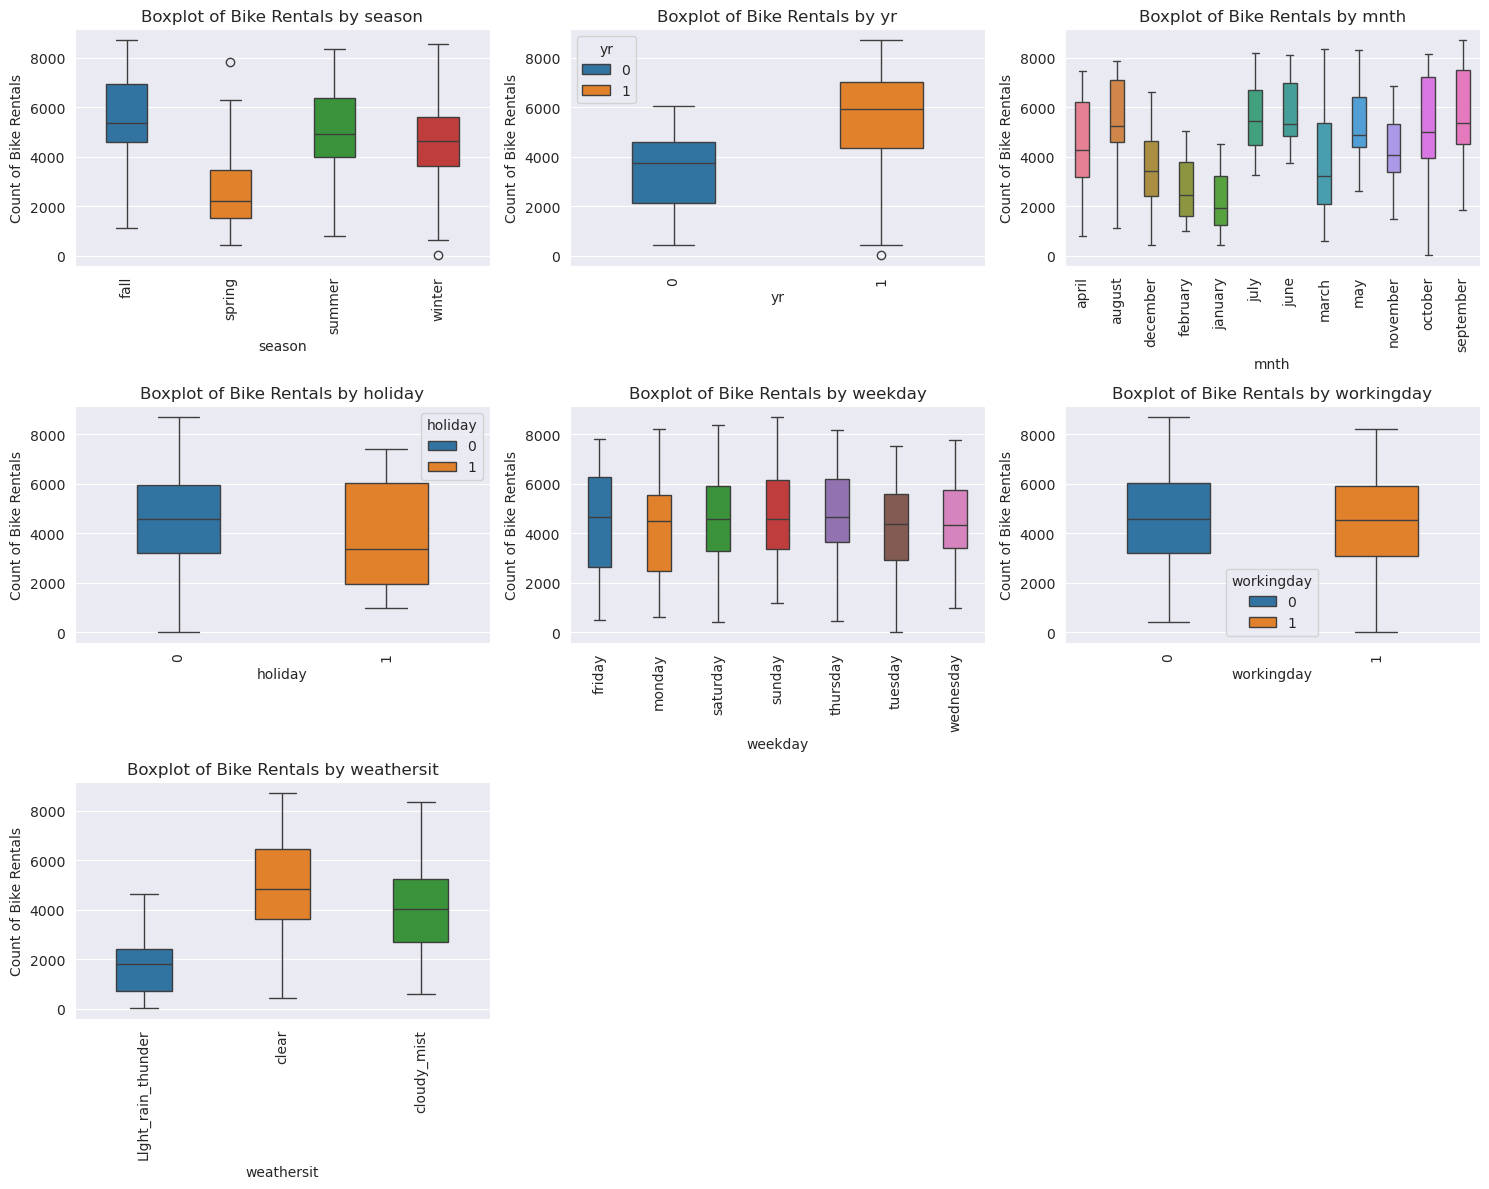

In [20]:
cat_vars = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

plt.figure(figsize=(15, 12))
for i, j in enumerate(cat_vars, 1):
    plt.subplot(3, 3, i)
    df_boxplot = df[['cnt', j]]
    df_boxplot[j] = df[j].astype('category')
    
    sns.boxplot(x=j, y='cnt', data=df_boxplot, width=0.4, hue=j)
    plt.title(f'Boxplot of Bike Rentals by {j}')
    plt.xlabel(j)
    plt.ylabel('Count of Bike Rentals')
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [21]:
# Analysis:-
# fall has the highest average rentals, followed closely by summer.

# 2019 sees a notable increase with a median rise of approximately 200 rentals compared to 2018.

# holidays generally result in lower rental counts compared to working days.

# overall no significant difference in rentals across weekdays is observed.
# thursdays andd sundays stand out with higher variability in reantal counts compared to other weekdays.


In [22]:
# checking outlier in 'spring' as we saw in boxplot.median is around 2000 and 7000> seems like an outlier so we can drop this one row.

In [23]:
df.shape

(730, 11)

In [24]:
df[(df['season']=='spring') & (df['cnt'] > 7000)]

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
440,spring,1,march,0,sunday,0,cloudy_mist,21.080847,75.5833,7.417168,7836


In [25]:
# dropping cnt > 7000 for spring
df.drop(df[(df['season']=='spring') & (df['cnt'] > 7000)].index,inplace=True)

In [26]:
df.shape

(729, 11)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 729 entries, 0 to 729
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      729 non-null    object 
 1   yr          729 non-null    int64  
 2   mnth        729 non-null    object 
 3   holiday     729 non-null    int64  
 4   weekday     729 non-null    object 
 5   workingday  729 non-null    int64  
 6   weathersit  729 non-null    object 
 7   temp        729 non-null    float64
 8   hum         729 non-null    float64
 9   windspeed   729 non-null    float64
 10  cnt         729 non-null    int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 68.3+ KB


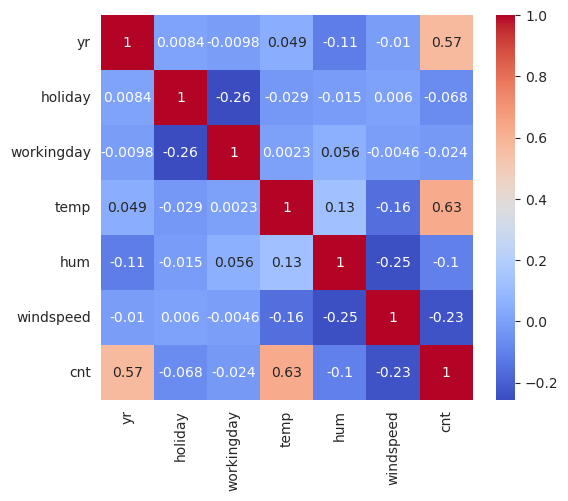

In [28]:
# uderstanding correlation among categorical and numerical values
# checking correlation

numeric_col = df.select_dtypes(include=['number'])

plt.figure(figsize=(6,5))
sns.heatmap(numeric_col.corr(),cmap="coolwarm",annot=True)
plt.show()

In [29]:
# Analysis:-
# Highest correlation with 'cnt' is seen in 'temp' followed by 'yr'.

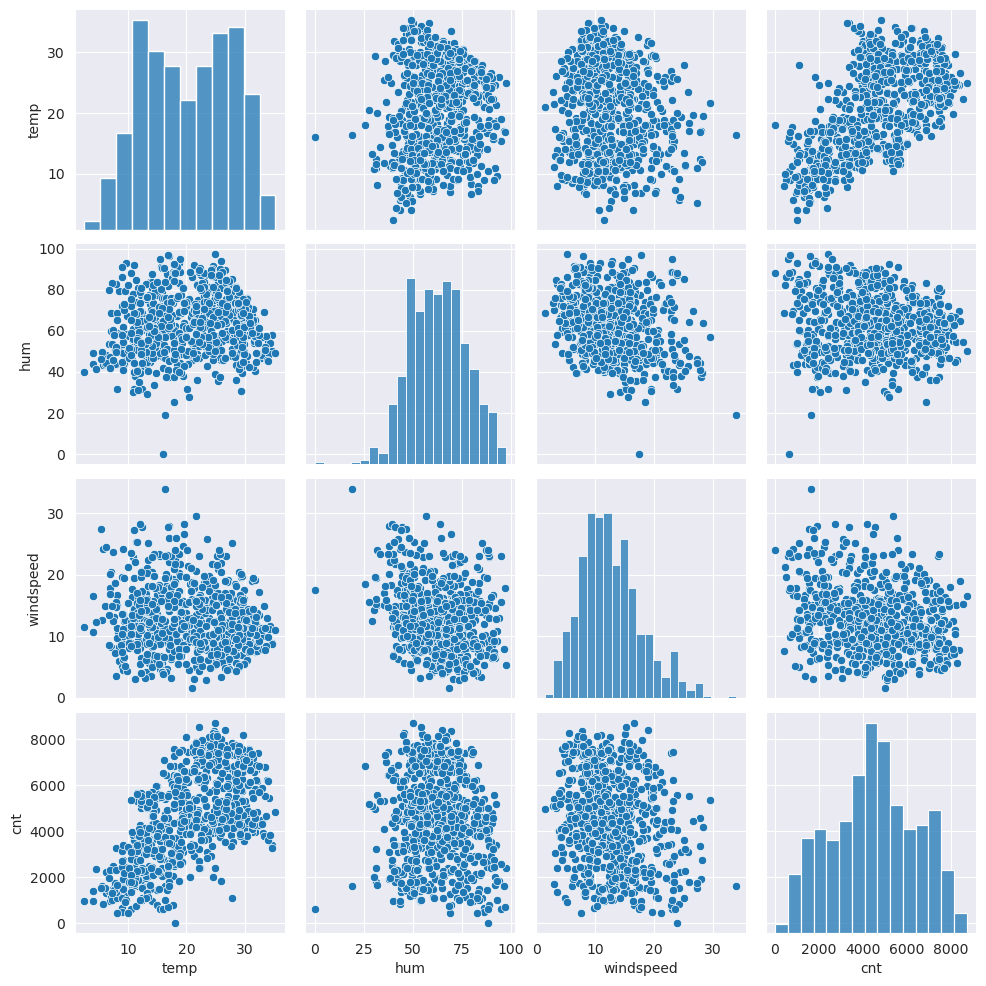

In [30]:
sns.pairplot(df,vars=['temp','hum','windspeed','cnt']);

Data Preparation

In [31]:
# creating dummy variables
season_dum = pd.get_dummies(df['season'],drop_first=True,dtype=int)
mnth_dum = pd.get_dummies(df['mnth'],drop_first=True,dtype=int)
weekday_dum = pd.get_dummies(df['weekday'],drop_first=True,dtype=int)
weathersit_dum = pd.get_dummies(df['weathersit'],drop_first=True,dtype=int)

In [32]:
# Adding indicator variable columns to the dataset. Dropping original columns
df = pd.concat([df,season_dum,mnth_dum,weekday_dum,weathersit_dum],axis=1)
df.drop(columns=['season','mnth','weekday','weathersit'],inplace=True)

In [33]:
df.shape

(729, 29)

In [34]:
df.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,spring,summer,winter,...,october,september,monday,saturday,sunday,thursday,tuesday,wednesday,clear,cloudy_mist
0,0,0,1,14.110847,80.5833,10.749882,985,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0,0,1,14.902598,69.6087,16.652113,801,1,0,0,...,0,0,0,0,0,0,1,0,0,1
2,0,0,1,8.050924,43.7273,16.636703,1349,1,0,0,...,0,0,0,0,0,0,0,1,1,0
3,0,0,1,8.200000,59.0435,10.739832,1562,1,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0,0,1,9.305237,43.6957,12.522300,1600,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [35]:
# Spliting the into data training and testing sets
np.random.seed(30)
df_train, df_test = train_test_split(df,train_size=0.8, test_size=0.2, random_state=100)

In [36]:
df_train.shape

(583, 29)

In [37]:
df_test.shape

(146, 29)

In [38]:
# Rescaling the features
# As you saw in the demonstration for Simple Linear Regression, scaling doesn’t impact your model. Here we can see thatall the columns have small integer values. So it is extremely important to rescale the variables so that they have a comparable scale. If we don’t have comparable scales, then some of the coefficients as obtained by fitting the regression model might be very large or very small as compared to the other coefficients. This might become very annoying at the time of model evaluation.


# we will use MinMax scaling.

In [39]:
scaler = MinMaxScaler()

In [40]:
# apply scaler
num_vars = ['temp','hum','windspeed']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

In [41]:
df_train.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,spring,summer,winter,...,october,september,monday,saturday,sunday,thursday,tuesday,wednesday,clear,cloudy_mist
366,1,1,0,0.266546,0.392928,0.617769,1951,1,0,0,...,0,0,0,0,0,0,0,1,1,0
328,0,0,0,0.393589,0.663375,0.121661,2792,0,0,1,...,0,0,0,0,1,0,0,0,1,0
44,0,0,1,0.443431,0.387290,0.807474,1913,1,0,0,...,0,0,0,0,0,0,0,1,1,0
592,1,0,1,0.822438,0.534994,0.213888,7605,0,0,0,...,0,0,0,0,0,0,0,0,1,0
546,1,0,1,0.942889,0.534564,0.271359,5531,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [42]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
yr,583.0,0.512864,0.500264,0.0,0.000000,1.000000,1.000000,1.0
holiday,583.0,0.024014,0.153223,0.0,0.000000,0.000000,0.000000,1.0
workingday,583.0,0.718696,0.450021,0.0,0.000000,1.000000,1.000000,1.0
temp,583.0,0.538465,0.225182,0.0,0.347901,0.538962,0.738848,1.0
hum,583.0,0.647261,0.145308,0.0,0.535852,0.650064,0.753113,1.0
windspeed,583.0,0.316354,0.169606,0.0,0.197844,0.288763,0.407759,1.0
cnt,583.0,4523.879931,1951.705499,431.0,3123.000000,4563.000000,6063.000000,8714.0
spring,583.0,0.250429,0.433632,0.0,0.000000,0.000000,0.500000,1.0
summer,583.0,0.245283,0.430624,0.0,0.000000,0.000000,0.000000,1.0
winter,583.0,0.246998,0.431636,0.0,0.000000,0.000000,0.000000,1.0


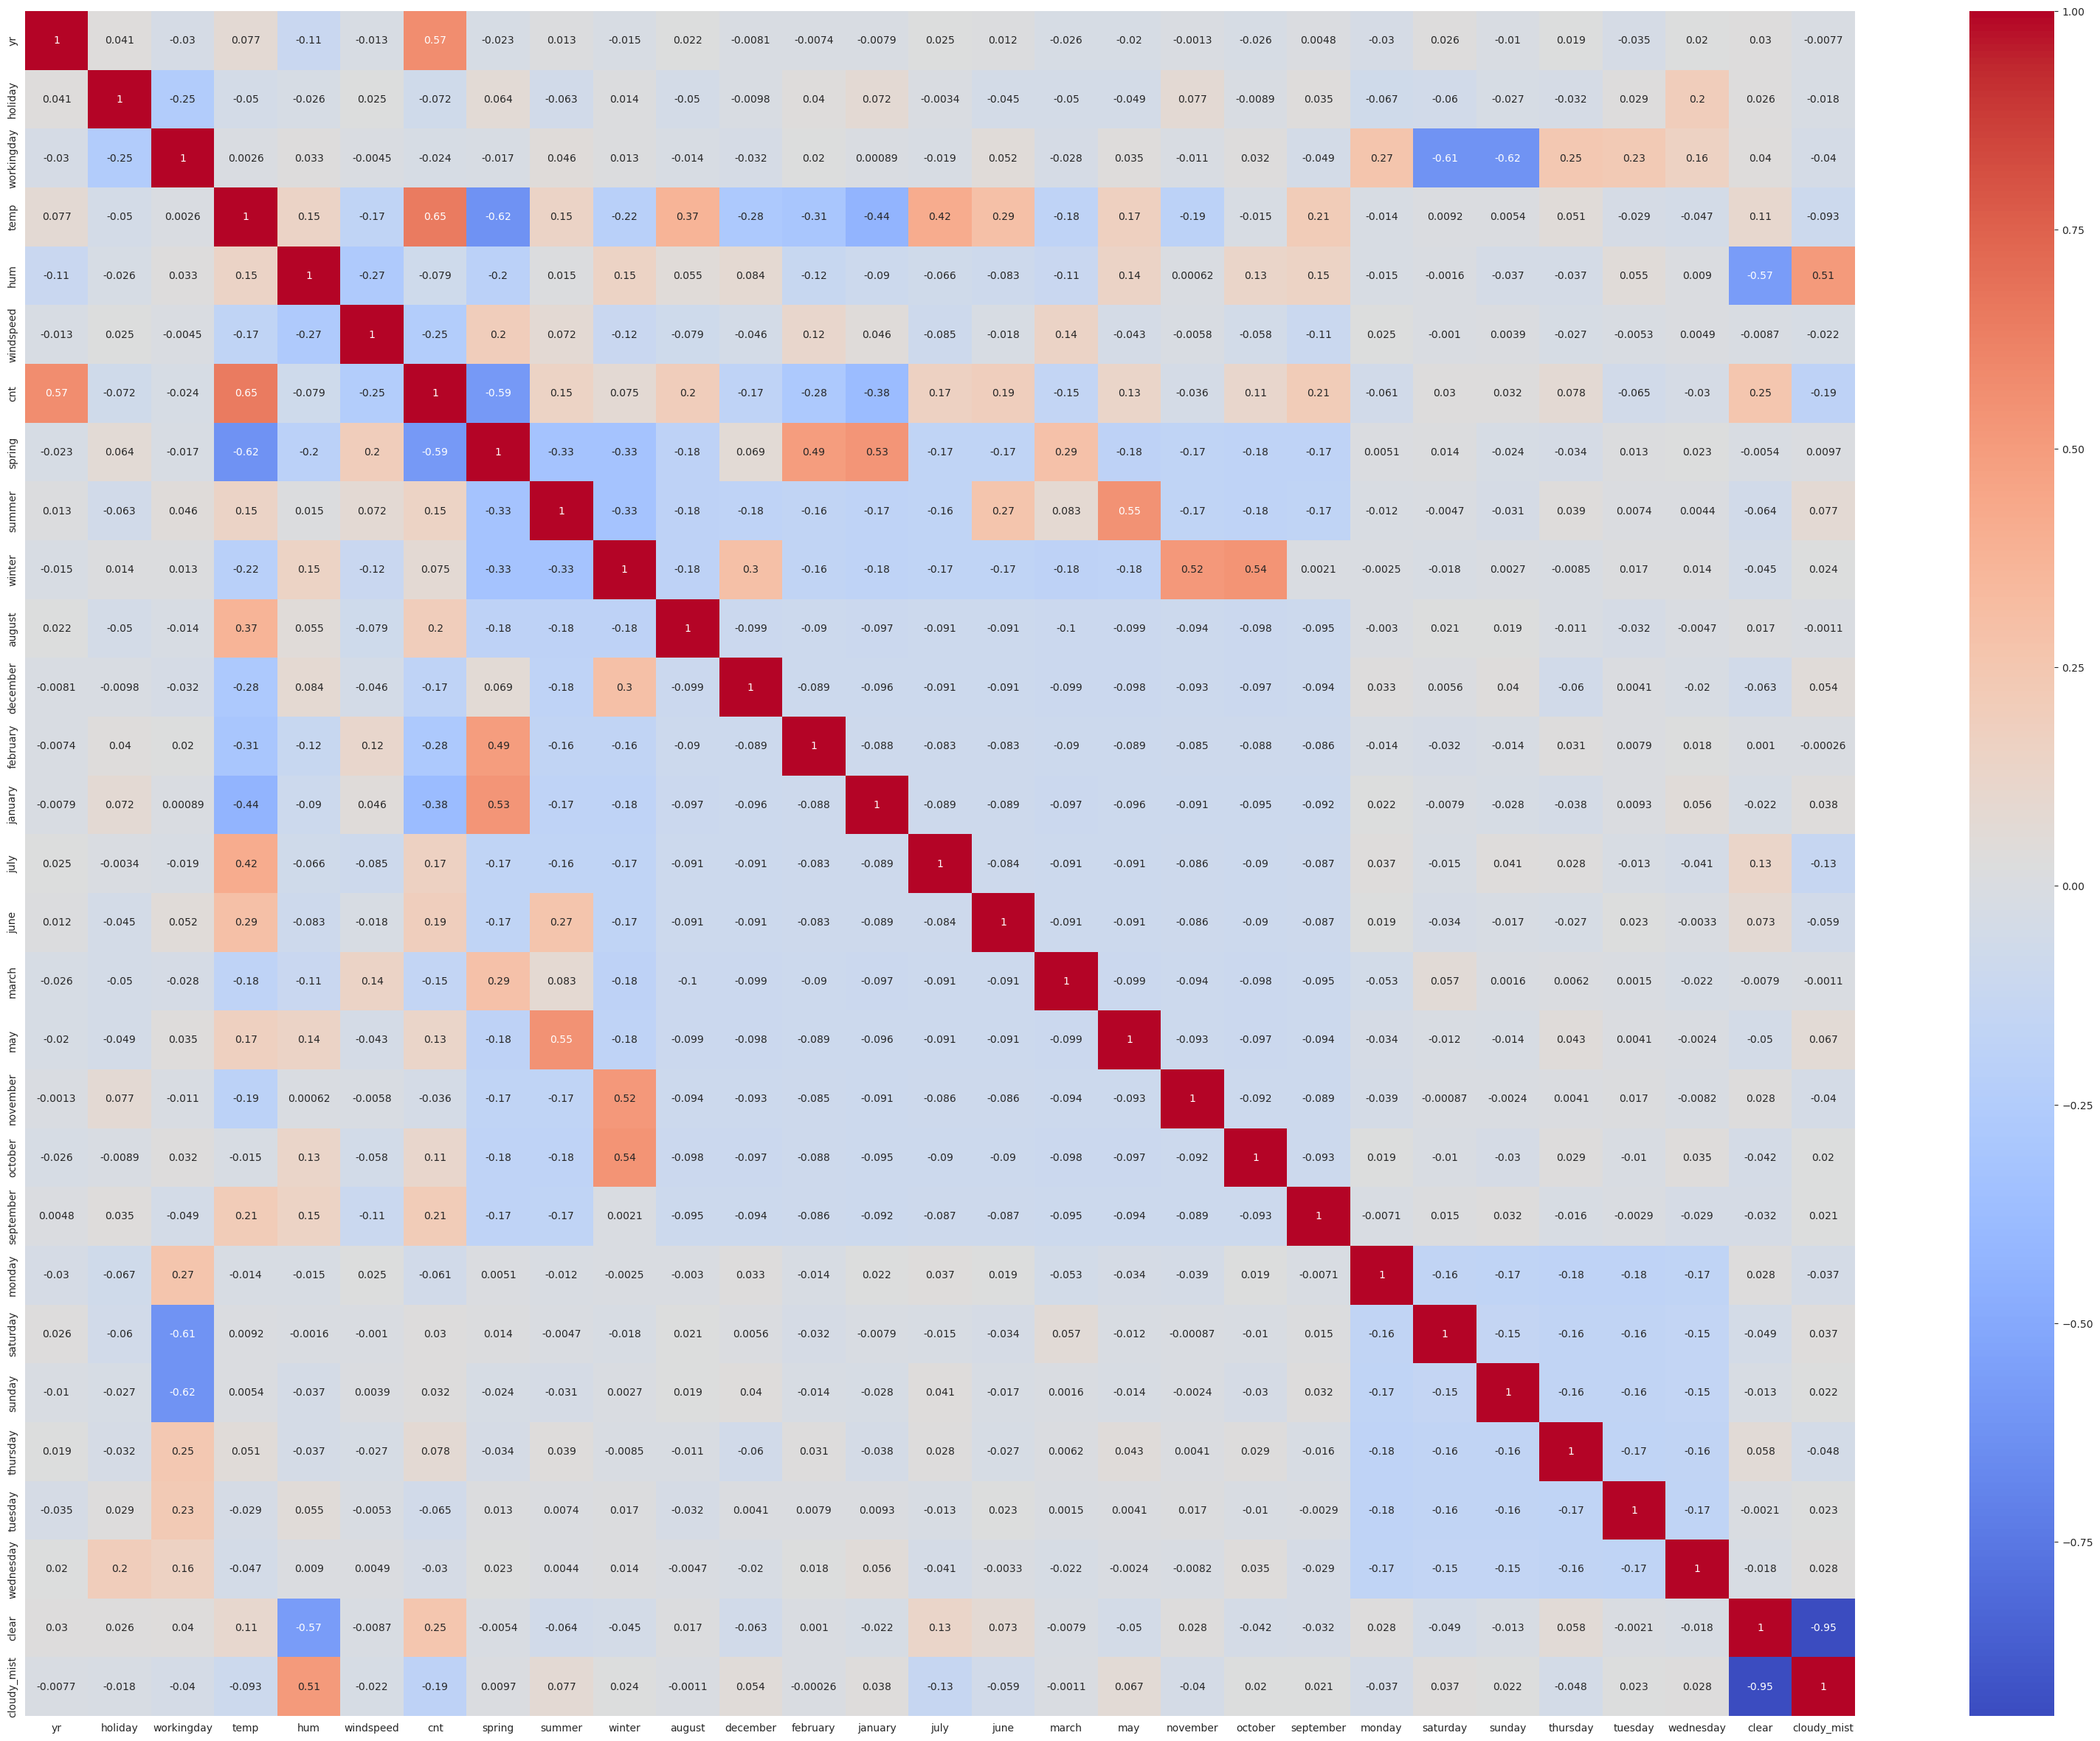

In [43]:
# Let's check the correlation coefficients to see which variables are highly correlated
plt.figure(figsize=(40,30))
sns.heatmap(df_train.corr(),annot=True,cmap='coolwarm')
plt.show()

In [44]:
# dividing into x and y sets for the model building

In [45]:
# Separating the target variable "cnt" from the features in the training data
y_train = df_train.pop("cnt")
x_train = df_train

Building a linear model

Model-1

In [46]:
# add a constant column to the dataframe x_train using statsmodels
x_train_lm = sm.add_constant(x_train)

In [47]:
# fit OLS(ordinary least sqaures) regression model using statsmodels
mlr1 = sm.OLS(y_train,x_train_lm).fit()

In [48]:
print(mlr1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     123.3
Date:                Fri, 09 Aug 2024   Prob (F-statistic):          1.80e-217
Time:                        23:37:41   Log-Likelihood:                -4667.1
No. Observations:                 583   AIC:                             9392.
Df Residuals:                     554   BIC:                             9519.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         359.9020    904.696      0.398      

In [49]:
# checking VIF(variance inflation factor)

# VIF gives a basic quantitative idea about how much the feature variables are correlated with each other. It is an extremely important parameter to test our linear model.

In [50]:
vif = pd.DataFrame()
vif['Features'] = x_train.columns
vif['VIF'] = [variance_inflation_factor(x_train.values,i) for i in range(x_train.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF',ascending=False)
vif

,Features,VIF
2,workingday,108.55
3,temp,45.90
4,hum,41.47
26,clear,31.45
21,saturday,19.88
22,sunday,19.70
27,cloudy_mist,15.59
6,spring,13.78
8,winter,11.40
7,summer,10.16


In [51]:
# we generally want a VIF that is less than 5. So there are clearly some variables we need to drop.

In [52]:
# It can be seen some variables have very high VIF values and high p_value so its better to use RFE(recursive feature elimination) to decide the best variables

In [53]:
lm = LinearRegression()
lm.fit(x_train,y_train)

LinearRegression()

In [54]:
rfe = RFE(lm,n_features_to_select=20)
rfe = rfe.fit(x_train,y_train)
rfe

RFE(estimator=LinearRegression(), n_features_to_select=20)

In [55]:
rfe_table = pd.DataFrame(list(zip(x_train.columns,rfe.support_,rfe.ranking_)),columns=['feature','support','rank'])
rfe_table.sort_values(by='rank',ascending=True)

,feature,support,rank
0,yr,True,1
24,tuesday,True,1
22,sunday,True,1
21,saturday,True,1
20,monday,True,1
19,september,True,1
17,november,True,1
16,may,True,1
26,clear,True,1
12,january,True,1


In [56]:
# selecting columns based of RFE
selected_features = x_train.columns[rfe.support_]
selected_features

Index(['yr', 'workingday', 'temp', 'hum', 'windspeed', 'spring', 'winter',
       'december', 'february', 'january', 'july', 'may', 'november',
       'september', 'monday', 'saturday', 'sunday', 'tuesday', 'clear',
       'cloudy_mist'],
      dtype='object')

In [57]:
# selecting for model creation 
x_train_rfe = x_train[selected_features]

In [58]:
x_train_rfe.head()

,yr,workingday,temp,hum,windspeed,spring,winter,december,february,january,july,may,november,september,monday,saturday,sunday,tuesday,clear,cloudy_mist
366,1,0,0.266546,0.392928,0.617769,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
328,0,0,0.393589,0.663375,0.121661,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0
44,0,1,0.443431,0.387290,0.807474,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
592,1,1,0.822438,0.534994,0.213888,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
546,1,1,0.942889,0.534564,0.271359,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0


Model-2 : using RFE

In [59]:
x_train_lm = sm.add_constant(x_train_rfe) # add a constant to the dataframe x_train_rfe using statsmodels

mlr2 = sm.OLS(y_train, x_train_lm).fit() # fit OLS regression

print(mlr2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     173.9
Date:                Fri, 09 Aug 2024   Prob (F-statistic):          1.74e-225
Time:                        23:37:44   Log-Likelihood:                -4668.8
No. Observations:                 583   AIC:                             9380.
Df Residuals:                     562   BIC:                             9471.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         642.5594    426.070      1.508      

In [60]:
# checkig VIF
vif = pd.DataFrame()
vif['Features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values,i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF',ascending=False)
vif

,Features,VIF
3,hum,28.91
1,workingday,25.17
2,temp,23.98
18,clear,19.99
19,cloudy_mist,11.41
16,sunday,5.32
15,saturday,5.22
5,spring,4.98
4,windspeed,4.56
6,winter,3.11


In [61]:
# removing the variable 'hum' based on its very high VIF value
x_train_rfe.drop(['hum'],axis=1,inplace=True)

Model-3

In [62]:
x_train_rfe = sm.add_constant(x_train_rfe) # add a constant to the dataframe x_train_rfe using statsmodels

mlr3 = sm.OLS(y_train,x_train_rfe).fit() # fit OLS regression

print(mlr3.summary())


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     174.5
Date:                Fri, 09 Aug 2024   Prob (F-statistic):          1.99e-221
Time:                        23:37:46   Log-Likelihood:                -4681.3
No. Observations:                 583   AIC:                             9403.
Df Residuals:                     563   BIC:                             9490.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -554.5797    358.124     -1.549      

In [63]:
# checkig VIF
x_train_rfe.drop(['const'],axis=1,inplace=True)
vif = pd.DataFrame()
vif['Features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values,i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF',ascending=False)
vif

,Features,VIF
1,workingday,21.21
17,clear,19.95
2,temp,18.45
18,cloudy_mist,10.99
4,spring,4.78
15,sunday,4.67
14,saturday,4.55
3,windspeed,4.53
5,winter,2.87
8,january,2.37


In [64]:
# Removing the variable 'workingday' based on its very high VIF value
x_train_rfe.drop(['workingday'],axis=1,inplace=True)

Model-4

In [65]:
x_train_rfe = sm.add_constant(x_train_rfe) # add a constant to the dataframe x_train_rfe using statsmodels

mlr4 = sm.OLS(y_train,x_train_rfe).fit() # fit OLS regression

print(mlr4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     179.6
Date:                Fri, 09 Aug 2024   Prob (F-statistic):          8.57e-220
Time:                        23:37:47   Log-Likelihood:                -4687.9
No. Observations:                 583   AIC:                             9414.
Df Residuals:                     564   BIC:                             9497.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         240.3215    284.890      0.844      

In [66]:
# checkig VIF
x_train_rfe.drop(['const'],axis=1,inplace=True)
vif = pd.DataFrame()
vif['Features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values,i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF',ascending=False)
vif

,Features,VIF
1,temp,15.76
16,clear,15.23
17,cloudy_mist,8.31
3,spring,4.62
2,windspeed,4.31
4,winter,2.73
7,january,2.36
0,yr,2.09
6,february,2.08
10,november,1.76


In [67]:
# Removing the varuable 'temp' based on its very high VIF value
x_train_rfe.drop(['temp'],axis=1,inplace=True)

Model-5

In [68]:
x_train_rfe = sm.add_constant(x_train_rfe) # add a constant to the dataframe x_train_rfe using statsmodels

mlr5 = sm.OLS(y_train,x_train_rfe).fit() # fit OLS regression

print(mlr5.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     142.5
Date:                Fri, 09 Aug 2024   Prob (F-statistic):          1.98e-191
Time:                        23:37:48   Log-Likelihood:                -4758.4
No. Observations:                 583   AIC:                             9553.
Df Residuals:                     565   BIC:                             9631.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2290.4716    261.823      8.748      

In [69]:
# checkig VIF
x_train_rfe.drop(['const'],axis=1,inplace=True)
vif = pd.DataFrame()
vif['Features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values,i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF',ascending=False)
vif

,Features,VIF
15,clear,5.50
1,windspeed,4.23
2,spring,4.19
16,cloudy_mist,3.47
3,winter,2.67
6,january,2.17
0,yr,2.06
5,february,2.02
9,november,1.70
4,december,1.57


In [70]:
# VIF is control!

In [71]:
# Removing the variable 'sunday' based on its very high p value
x_train_rfe.drop(['sunday'],axis=1,inplace=True)

Model-6

In [72]:
x_train_rfe = sm.add_constant(x_train_rfe) # add a constant to the dataframe x_train_rfe using statsmodels

mlr6 = sm.OLS(y_train,x_train_rfe).fit() # fit OLS regression

print(mlr6.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     151.5
Date:                Fri, 09 Aug 2024   Prob (F-statistic):          1.93e-192
Time:                        23:37:49   Log-Likelihood:                -4758.6
No. Observations:                 583   AIC:                             9551.
Df Residuals:                     566   BIC:                             9625.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2300.4101    261.211      8.807      

In [73]:
# checkig VIF
x_train_rfe.drop(['const'],axis=1,inplace=True)
vif = pd.DataFrame()
vif['Features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values,i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF',ascending=False)
vif

,Features,VIF
14,clear,5.28
1,windspeed,4.22
2,spring,4.19
15,cloudy_mist,3.32
3,winter,2.67
6,january,2.17
0,yr,2.06
5,february,2.02
9,november,1.70
4,december,1.56


In [74]:
# removing the variable 'saturday' on its very high p value
x_train_rfe.drop(['saturday'],axis=1,inplace=True)

Model-7

In [75]:
x_train_rfe = sm.add_constant(x_train_rfe) # add a constant to the dataframe x_train_rfe using statsmodels

mlr7 = sm.OLS(y_train,x_train_rfe).fit() # fit OLS regression

print(mlr7.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     161.6
Date:                Fri, 09 Aug 2024   Prob (F-statistic):          2.21e-193
Time:                        23:37:50   Log-Likelihood:                -4759.0
No. Observations:                 583   AIC:                             9550.
Df Residuals:                     567   BIC:                             9620.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2325.6352    259.611      8.958      

In [76]:
# checkig VIF
x_train_rfe.drop(['const'],axis=1,inplace=True)
vif = pd.DataFrame()
vif['Features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values,i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF',ascending=False)
vif

,Features,VIF
13,clear,5.17
1,windspeed,4.22
2,spring,4.17
14,cloudy_mist,3.24
3,winter,2.67
6,january,2.17
0,yr,2.06
5,february,2.01
9,november,1.70
4,december,1.56


In [77]:
# removing the variable 'july' based on its very high p value
x_train_rfe.drop(['july'],axis=1,inplace=True)

Model-8

In [78]:
x_train_rfe = sm.add_constant(x_train_rfe) # add a constant to the dataframe x_train_rfe using statsmodels

mlr8 = sm.OLS(y_train,x_train_rfe).fit() # fit OLS regression

print(mlr8.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     173.0
Date:                Fri, 09 Aug 2024   Prob (F-statistic):          3.28e-194
Time:                        23:37:51   Log-Likelihood:                -4759.7
No. Observations:                 583   AIC:                             9549.
Df Residuals:                     568   BIC:                             9615.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2373.2370    256.541      9.251      

In [79]:
# checkig VIF
x_train_rfe.drop(['const'],axis=1,inplace=True)
vif = pd.DataFrame()
vif['Features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values,i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF',ascending=False)
vif

,Features,VIF
12,clear,4.65
1,windspeed,4.21
2,spring,4.04
13,cloudy_mist,3.08
3,winter,2.56
6,january,2.17
0,yr,2.06
5,february,2.01
8,november,1.69
4,december,1.56


In [80]:
# Removing the variable 'may' based on its very high p value
x_train_rfe.drop(['may'],axis=1,inplace=True)

Model-9

In [81]:
x_train_rfe = sm.add_constant(x_train_rfe) # add a constant to the dataframe x_train_rfe using statsmodels

mlr9 = sm.OLS(y_train,x_train_rfe).fit() # fit OLS regression

print(mlr9.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     185.7
Date:                Fri, 09 Aug 2024   Prob (F-statistic):          6.93e-195
Time:                        23:37:51   Log-Likelihood:                -4760.8
No. Observations:                 583   AIC:                             9550.
Df Residuals:                     569   BIC:                             9611.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2407.7445    255.730      9.415      

In [82]:
# checkig VIF
x_train_rfe.drop(['const'],axis=1,inplace=True)
vif = pd.DataFrame()
vif['Features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values,i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF',ascending=False)
vif

,Features,VIF
11,clear,4.35
1,windspeed,4.21
2,spring,3.93
12,cloudy_mist,2.83
3,winter,2.47
6,january,2.17
0,yr,2.06
5,february,2.01
7,november,1.69
4,december,1.56


In [83]:
# Removing the variable 'winter' based on its very high p value
x_train_rfe.drop(['winter'],axis=1,inplace=True)

Model-10

In [84]:
x_train_rfe = sm.add_constant(x_train_rfe) # add a constant to the dataframe x_train_rfe using statsmodels

mlr10 = sm.OLS(y_train,x_train_rfe).fit() # fit OLS regression

print(mlr10.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     200.0
Date:                Fri, 09 Aug 2024   Prob (F-statistic):          2.64e-195
Time:                        23:37:52   Log-Likelihood:                -4762.6
No. Observations:                 583   AIC:                             9551.
Df Residuals:                     570   BIC:                             9608.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2478.2540    253.425      9.779      

Testing the Model with the best scores on the test set

In the above scores, mlr10 appears to be the best model. Let's evaluate this model on the test set.

In [85]:
# Add a constant column to the DataFrame 'x_train_rfe' using statsmodels
x_train_sm = sm.add_constant(x_train_rfe)

In [86]:
# Predict the target variable 'y_train' using the trained regression model 'mlr13' and the DataFrame 'x_train_sm'

y_train_pred = mlr10.predict(x_train_sm)

In [87]:
# Model Evaluation

print("R^2 : ", r2_score(y_train,y_train_pred))

print("Adjusted R^2 : ", 1 - (1-r2_score(y_train, y_train_pred))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1))

print("MAE : ",mean_absolute_error(y_train, y_train_pred))

print("MSE : ",mean_squared_error(y_train, y_train_pred))

print("RMSE : ",np.sqrt(mean_squared_error(y_train, y_train_pred)))

R^2 :  0.8081188246156155
Adjusted R^2 :  0.7984208590727224
MAE :  650.6402108460753
MSE :  729651.3181005208
RMSE :  854.1962995123081


In [88]:
# Making Predictions Using the Final Model
num_vars = num_vars = ['temp','hum','windspeed']

df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [89]:
df_test.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,spring,summer,winter,...,october,september,monday,saturday,sunday,thursday,tuesday,wednesday,clear,cloudy_mist
184,0,1,0,0.837241,0.509768,0.172127,6043,0,0,0,...,0,0,0,0,0,0,0,1,0,1
639,1,0,1,0.656765,0.852259,0.239115,4639,0,0,1,...,1,0,0,0,0,0,0,1,0,0
299,0,0,0,0.496221,0.766179,0.510871,2659,0,0,1,...,1,0,0,1,0,0,0,0,0,1
221,0,0,1,0.890387,0.196582,0.518139,4780,0,0,0,...,0,0,0,0,0,0,0,0,1,0
152,0,0,0,0.821739,0.021978,0.786227,4968,0,1,0,...,0,0,0,1,0,0,0,0,1,0


In [90]:
y_test = df_test.pop('cnt')
x_test = df_test

In [91]:
x_test_mlr10 = sm.add_constant(x_test)

In [92]:
x_train_rfe.head()

,const,yr,windspeed,spring,december,february,january,november,september,monday,tuesday,clear,cloudy_mist
366,1.0,1,0.617769,1,0,0,1,0,0,0,0,1,0
328,1.0,0,0.121661,0,0,0,0,1,0,0,0,1,0
44,1.0,0,0.807474,1,0,1,0,0,0,0,0,1,0
592,1.0,1,0.213888,0,0,0,0,0,0,0,0,1,0
546,1.0,1,0.271359,0,0,0,0,0,0,1,0,1,0


In [93]:
x_test_mlr10 = x_test_mlr10[['yr','windspeed','spring','december','february','january','november','september','monday' ,'tuesday','clear','cloudy_mist']]

In [94]:
x_test_mlr10.head()

,yr,windspeed,spring,december,february,january,november,september,monday,tuesday,clear,cloudy_mist
184,0,0.172127,0,0,0,0,0,0,0,0,0,1
639,1,0.239115,0,0,0,0,0,0,0,0,0,0
299,0,0.510871,0,0,0,0,0,0,0,0,0,1
221,0,0.518139,0,0,0,0,0,0,0,0,1,0
152,0,0.786227,0,0,0,0,0,0,0,0,1,0


In [95]:
# Adding comstant
x_test_mlr10 = sm.add_constant(x_test_mlr10)

In [96]:
# Making predictions
y_test_pred_mlr10 = mlr10.predict(x_test_mlr10)

In [97]:
# Model Evaluation

print("R^2 : ", r2_score(y_test,y_test_pred_mlr10))

print("Adjusted R^2 : ", 1 - (1-r2_score(y_test, y_test_pred_mlr10))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1))

print("MAE : ",mean_absolute_error(y_test, y_test_pred_mlr10))

print("MSE : ",mean_squared_error(y_test, y_test_pred_mlr10))

print("RMSE : ",np.sqrt(mean_squared_error(y_test, y_test_pred_mlr10)))

R^2 :  0.7314540618269911
Adjusted R^2 :  0.7178813429301604
MAE :  726.4566869226433
MSE :  925490.7987624699
RMSE :  962.0243233736193
